# Fish Detector

This notebook explores the images and trains a fish-detection model for the [Nature Conservancy Fisheries Competition](https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring) hosted on Kaggle. This notebook assumes the following folder structure:

 - data
  - train (from Kaggle)
    - ALB
    - BET
    - ...
  - test_stg1 (from Kaggle)
  - [kaggleNatureConservancy](https://github.com/nathanie/kaggleNatureConservancy)
  - markers.csv
  - sample_submission_stg1.csv
  - train.csv (generated later)
 - models
  - \*.h5
 - shiny_annotater.R (for generating markers.csv)

We start with an exploration and then preparation of the dataset.

## Data Preparation

### Setup

import libraries

In [1]:
%matplotlib inline

# system libraries
import os
from glob import glob
import logging

# numerical,image and plotting stuff
import pandas as pd
import numpy as np
from PIL import Image
from skimage import io
import skimage.transform as tf
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid", {'axes.grid' : False})

### Files

The directory structure of this project places images in their labelled folders, which facilitates easy 're-labeling' just by moving files around. During the annotation phase, some 'mis-labeled' pictures were discovered and have been manually moved into different folders.

Let's begin by getting all the image file names and their associated classes from their latest location.

In [2]:
# get all image file names and associated class from their latest location
class_folders = glob('data/train/*')
files = [glob(cls + '/*') for cls in class_folders] # put class info with file name
files = [img for cls in files for img in cls]
df = pd.DataFrame({'fpath':files,'w':0,'h':0})
df['category'] = df.fpath.str.extract('data/train/([a-zA-Z]*)/img', expand=False) # extract class
df['fname'] = df.fpath.str.extract('data/train/[a-zA-Z]*/([a-zA-Z0-9_.]*)', expand=False) # extract file name
df.head()

fpath  h  w category          fname
0  data/train/ALB/img_00003.jpg  0  0      ALB  img_00003.jpg
1  data/train/ALB/img_00010.jpg  0  0      ALB  img_00010.jpg
2  data/train/ALB/img_00012.jpg  0  0      ALB  img_00012.jpg
3  data/train/ALB/img_00015.jpg  0  0      ALB  img_00015.jpg
4  data/train/ALB/img_00019.jpg  0  0      ALB  img_00019.jpg

### Dimensions

To get a feel for how large the pictures, we get the width and height of each picture, and plot their bi-variate distribution.

                 h            w
count  3777.000000  3777.000000
mean    755.656871  1281.985703
std      84.888042    53.990846
min     670.000000  1192.000000
25%     720.000000  1280.000000
50%     720.000000  1280.000000
75%     750.000000  1280.000000
max     974.000000  1732.000000


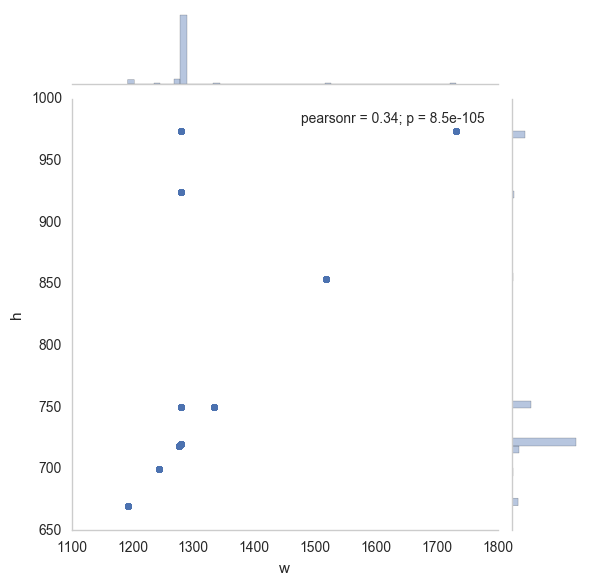

In [3]:
# get a distribution of w,h of all images ~4s for PIL's Image.open, 
# much longer for skimage.io.imread
for idx in df.index:
    im = Image.open(df.ix[idx].fpath)
    df.ix[idx,['w','h']] = im.size

df.to_csv('data/train.csv',index=False)
print(df.describe())
sns.jointplot(data=df,x='w',y='h',kind='scatter')

Height and width are approximately 720 x 1280. If we were to read all the files into memory, that would take up 3777 images \* 720 \* 1280 \* 3 = 10.4GB, which is not too much for modern computers. But to be memory-friendly and make this code accessible to others without the luxury of >= 16GB RAM, we'll write a generator to read in the files. Moreover, we would need a generator to perform various augmentations to our dataset to avoid over-fitting.

### Images

Let's see how the images look like with the following cell. If we re-run the following cell, we'll realize slowly that some of the pictures for the same class seem very similar, and could have been taken around the same time from the same camera from the same boat.

In [4]:
# sample an image per class of fish
fishes = df.groupby('category').apply(lambda x: x.sample(1))
print(fishes)
f = plt.figure(figsize=(12,20))
for i in range(len(fishes)):
    fpath = fishes.iloc[i]['fpath']
    img = io.imread(fpath)
    ax = plt.subplot(4,2,i+1)
    ax.imshow(img)
    ax.set_title(fpath)
    ax.axis('off')


                                        fpath    h     w category  \
category                                                            
ALB      1343    data/train/ALB/img_06367.jpg  720  1280      ALB   
BET      1760    data/train/BET/img_01350.jpg  854  1518      BET   
DOL      1925    data/train/DOL/img_00565.jpg  974  1280      DOL   
LAG      2044    data/train/LAG/img_01527.jpg  720  1280      LAG   
NoF      2522    data/train/NoF/img_06910.jpg  718  1276      NoF   
OTHER    2693  data/train/OTHER/img_03265.jpg  750  1280    OTHER   
SHARK    3005  data/train/SHARK/img_06220.jpg  974  1280    SHARK   
YFT      3688    data/train/YFT/img_07069.jpg  720  1280      YFT   

                       fname  
category                      
ALB      1343  img_06367.jpg  
BET      1760  img_01350.jpg  
DOL      1925  img_00565.jpg  
LAG      2044  img_01527.jpg  
NoF      2522  img_06910.jpg  
OTHER    2693  img_03265.jpg  
SHARK    3005  img_06220.jpg  
YFT      3688  img_07069.jpg  

### Annotations (Nathaniel's)

We read in all the annotations from [nathaniel's repository](https://github.com/nathanie/kaggleNatureConservancy) into a dataframe named `markers1`. The annotated json files should be in a folder titled `kaggleNatureConservancy` in the data folder.

As some of the annotations are just empty lists `[]` or lists of empty dictionaries `[{}]`, we perform some error handling to return `np.NaN` instead. We print out a list of the files without annotations as a simple sanity check.

In [5]:
f_json = glob('data/kaggleNatureConservancy/*.json')
markers1 = pd.DataFrame(columns=['annotations','class','filename'])
for i_json in f_json:
    print('reading %s' % i_json)
    i_markers = pd.read_json(i_json)
    markers1 = markers1.append(i_markers)

def split_annotations(an, default = (np.nan,np.nan,np.nan,np.nan)):
    try:
        return round(an[0]['x'],1), round(an[0]['y'],1), round(an[1]['x'],1), round(an[1]['y'],1)
    except KeyError:
        return default
    except IndexError:
        return default
    except Exception as e:
        print(e)
        return default

markers1['head_x'], markers1['head_y'], markers1['tail_x'], markers1['tail_y'] = \
    zip(* markers1['annotations'].map(split_annotations))
markers1 = markers1[['filename','head_x','head_y','tail_x','tail_y']]
print('\nfiles with missing labels:')
print(markers1[markers1['head_x'].isnull()])

reading data/kaggleNatureConservancy/alb_labels.json
reading data/kaggleNatureConservancy/bet_labels.json
reading data/kaggleNatureConservancy/dol_labels.json
reading data/kaggleNatureConservancy/lag_labels.json
reading data/kaggleNatureConservancy/other_labels.json
reading data/kaggleNatureConservancy/shark_labels.json
reading data/kaggleNatureConservancy/yft_labels.json

files with missing labels:
            filename  head_x  head_y  tail_x  tail_y
0         image2.jpg     NaN     NaN     NaN     NaN
112    img_00568.jpg     NaN     NaN     NaN     NaN
296    img_01354.jpg     NaN     NaN     NaN     NaN
316    img_01445.jpg     NaN     NaN     NaN     NaN
362    img_01660.jpg     NaN     NaN     NaN     NaN
701    img_03213.jpg     NaN     NaN     NaN     NaN
818    img_03694.jpg     NaN     NaN     NaN     NaN
903    img_04100.jpg     NaN     NaN     NaN     NaN
1364   img_06460.jpg     NaN     NaN     NaN     NaN
0     image00107.jpg     NaN     NaN     NaN     NaN
9      img_003

### Annotations (ours)

We read in our own annotations that is contained in `markers.csv`, then append it to the first set of annotations into a dataframe `markers`.

In [6]:
# read annotations 
markers2 = pd.read_csv('data/markers.csv')
markers2.head() 
# note the multiple annotations for the same image

filename  head_x  head_y  tail_x  tail_y
0  img_00003.jpg   314.4   377.4   595.5   191.4
1  img_00003.jpg   384.2   126.6   711.4   136.6
2  img_00003.jpg   675.6   108.4   982.3   171.5
3  img_00003.jpg   825.5   342.8  1095.1   449.4
4  img_00055.jpg   190.9   408.5   346.6   432.0

In [7]:
# combine annotations into a single data frame
markers = markers1.append(markers2)
markers = markers.sort_values(by=['filename','head_x','head_y','tail_x','tail_y'])
markers = markers.dropna()
markers.head(10)

filename  head_x  head_y  tail_x  tail_y
0     img_00003.jpg   314.4   377.4   595.5   191.4
1     img_00003.jpg   384.2   126.6   711.4   136.6
2     img_00003.jpg   675.6   108.4   982.3   171.5
1     img_00003.jpg   825.5   342.8  1095.1   449.4
3     img_00003.jpg   825.5   342.8  1095.1   449.4
1     img_00004.jpg   560.2   487.4   892.0   665.0
2686  img_00004.jpg   560.2   487.4   892.0   665.0
3483  img_00010.jpg   718.2   600.0   689.2   438.9
2     img_00010.jpg   721.6   606.1   688.1   433.6
3484  img_00010.jpg   846.0   407.3   910.7   319.3

As there are 'overlapping' annotations which are present in both datasets, but not exactly the same, we would need a simple function for de-duplicating them in each image. If the head and tail coords differ by less than a threshold (20px), we keep the first (nathaniel's) annotation. 

To prevent having to build a full cartesian product of all pairs of entries, we sort by the `filename` and the respective coordinate columns. Our task is then reduced to comparing adjacent records, which we achieve by adding a 1-shifted column that contains the previous row's coords :)

In [8]:
# add 1-shifted column of coordinates
markers['prev_head_x'] = markers.groupby('filename')['head_x'].shift()
markers['prev_tail_x'] = markers.groupby('filename')['tail_x'].shift()
markers['prev_head_y'] = markers.groupby('filename')['head_y'].shift()
markers['prev_tail_y'] = markers.groupby('filename')['tail_y'].shift()

def is_repeated(row,threshold=20):
    # if prev_head_x is na, it would be first coord in markers
    if np.isnan(row['prev_head_x']):
        return False
    else:
        diff_head_x = abs(row['head_x'] - row['prev_head_x'])
        diff_head_y = abs(row['head_y'] - row['prev_head_y'])
        diff_tail_x = abs(row['tail_x'] - row['prev_tail_x'])
        diff_tail_y = abs(row['tail_y'] - row['prev_tail_y'])
        if_similar = diff_head_x <= threshold and diff_head_y <= threshold and \
            diff_tail_x <= threshold and diff_tail_y <= threshold
        return if_similar

# see results
markers['is_repeated'] = markers.apply(is_repeated,axis=1)
markers

filename  head_x  head_y  tail_x  tail_y  prev_head_x  prev_tail_x  \
0     img_00003.jpg   314.4   377.4   595.5   191.4          NaN          NaN   
1     img_00003.jpg   384.2   126.6   711.4   136.6        314.4        595.5   
2     img_00003.jpg   675.6   108.4   982.3   171.5        384.2        711.4   
1     img_00003.jpg   825.5   342.8  1095.1   449.4        675.6        982.3   
3     img_00003.jpg   825.5   342.8  1095.1   449.4        825.5       1095.1   
1     img_00004.jpg   560.2   487.4   892.0   665.0          NaN          NaN   
2686  img_00004.jpg   560.2   487.4   892.0   665.0        560.2        892.0   
3483  img_00010.jpg   718.2   600.0   689.2   438.9          NaN          NaN   
2     img_00010.jpg   721.6   606.1   688.1   433.6        718.2        689.2   
3484  img_00010.jpg   846.0   407.3   910.7   319.3        721.6        688.1   
3     img_00012.jpg   492.2   514.0   602.7   681.4          NaN          NaN   
3485  img_00012.jpg   492.2   514.0   602.7   681.4        492.2        602.7   
2     img_00014.jpg   381.7   345.8   553.1   471.8          NaN          NaN   
2687  img_00014.jpg   381.7   345.8   553.1   471.8        381.7        553.1   
4     img_00015.jpg   258.0   359.6   435.7   396.2          NaN          NaN   
3486  img_00015.jpg   258.0   359.6   435.7   396.2        258.0        435.7   
5     img_00019.jpg   165.0   459.3   284.3   415.5          NaN          NaN   
3487  img_00019.jpg   165.0   459.3   284.3   415.5        165.0        284.3   
3488  img_00020.jpg   616.0   477.1   755.7   395.7          NaN          NaN   
3489  img_00020.jpg   636.4   716.3   701.2   528.6        616.0        755.7   
3490  img_00020.jpg   639.8   719.6   694.3   550.2        636.4        701.2   
3491  img_00020.jpg   656.9   423.9   728.4   350.9        639.8        694.3   
6     img_00020.jpg   712.9   675.2   800.3   491.0        656.9        728.4   
3492  img_00020.jpg   712.9   675.2   800.3   491.0        712.9        800.3   
3493  img_00020.jpg   714.8   676.4   823.8   487.1        712.9        800.3   
3494  img_00020.jpg   742.0   513.6   776.1   389.1        714.8        823.8   
3495  img_00020.jpg   803.4   460.5   837.5   347.5        742.0        776.1   
3     img_00021.jpg   891.1   620.4   885.5   414.5          NaN          NaN   
2688  img_00021.jpg   891.1   620.4   885.5   414.5        891.1        885.5   
4     img_00023.jpg   235.5   428.6   461.1   442.7          NaN          NaN   
...             ...     ...     ...     ...     ...          ...          ...   
3480  img_07891.jpg  1146.3   633.1   423.0   706.4       1146.3        423.0   
1713  img_07892.jpg   271.0   166.0   574.0   102.0          NaN          NaN   
1760  img_07892.jpg   271.0   166.0   574.0   102.0        271.0        574.0   
117   img_07898.jpg   387.8   459.7   596.4   456.8          NaN          NaN   
2108  img_07898.jpg   387.8   459.7   596.4   456.8        387.8        596.4   
733   img_07901.jpg   108.6   393.4   382.1   427.2          NaN          NaN   
3481  img_07901.jpg   108.6   393.4   382.1   427.2        108.6        382.1   
1714  img_07903.jpg   647.0   472.0   724.0   381.0          NaN          NaN   
1761  img_07903.jpg   647.0   472.0   724.0   381.0        647.0        724.0   
1715  img_07904.jpg   148.4   499.9   163.9   644.8          NaN          NaN   
1762  img_07904.jpg   148.4   499.9   163.9   644.8        148.4        163.9   
734   img_07911.jpg   760.0   197.4  1129.4   204.5          NaN          NaN   
3482  img_07911.jpg   760.0   197.4  1129.4   204.5        760.0       1129.4   
1716  img_07912.jpg   396.0   288.0   565.0   140.0          NaN          NaN   
1763  img_07912.jpg   396.0   288.0   565.0   140.0        396.0        565.0   
1717  img_07914.jpg   358.6   261.2   561.7   325.4          NaN          NaN   
1764  img_07914.jpg   358.6   261.2   561.7   325.4        358.6        561.7   
1718  img_07915.jpg   469.0   489.2   619.

Since the functions looks like it's working correctly, we do it on the `markers` data frame and drop the `prev_*` columns.

In [9]:
markers = markers.loc[(~markers['is_repeated']),\
                      ['filename','head_x','head_y','tail_x','tail_y']]

In [10]:
n_annotated = len(markers['filename'].unique())
n_total = len(df['fname'].unique())
n_NoF = len(df.loc[df['category']=='NoF','fname'].unique())

print('%d unique file names with >=1 annotation' % n_annotated)
print('%d file names in total' % n_total)
print('%d file names in NoF' % n_NoF)

3308 unique file names with >=1 annotation
3777 file names in total
470 file names in NoF


We perform a left join with the markers data frame to preserve the file names that do not have annotations.

In [11]:
df_full = pd.merge(left=df,right=markers,how='left',left_on='fname',right_on='filename')
print('df has %i rows' % len(df_full))
print(df_full.sample(10))
df_full.to_csv('data/train.csv', index=False, float_format='%.1f')

df has 4318 rows
                             fpath    h     w category          fname  \
2643  data/train/NoF/img_01579.jpg  720  1280      NoF  img_01579.jpg   
1456  data/train/ALB/img_05031.jpg  720  1280      ALB  img_05031.jpg   
572   data/train/ALB/img_01542.jpg  720  1280      ALB  img_01542.jpg   
3859  data/train/YFT/img_03480.jpg  720  1280      YFT  img_03480.jpg   
809   data/train/ALB/img_02189.jpg  720  1280      ALB  img_02189.jpg   
92    data/train/ALB/img_00264.jpg  720  1280      ALB  img_00264.jpg   
1444  data/train/ALB/img_04981.jpg  720  1280      ALB  img_04981.jpg   
1084  data/train/ALB/img_03374.jpg  720  1280      ALB  img_03374.jpg   
2923  data/train/NoF/img_06494.jpg  720  1280      NoF  img_06494.jpg   
2341  data/train/DOL/img_01397.jpg  974  1280      DOL  img_01397.jpg   

           filename  head_x  head_y  tail_x  tail_y  
2643            NaN     NaN     NaN     NaN     NaN  
1456  img_05031.jpg   352.5   470.9   504.6   462.7  
572   img_01542.j

We sample images and check the annotations to see that they are reasonably labeled.

Note the head and tail coordinates have not been normalized (just raw pixel position).

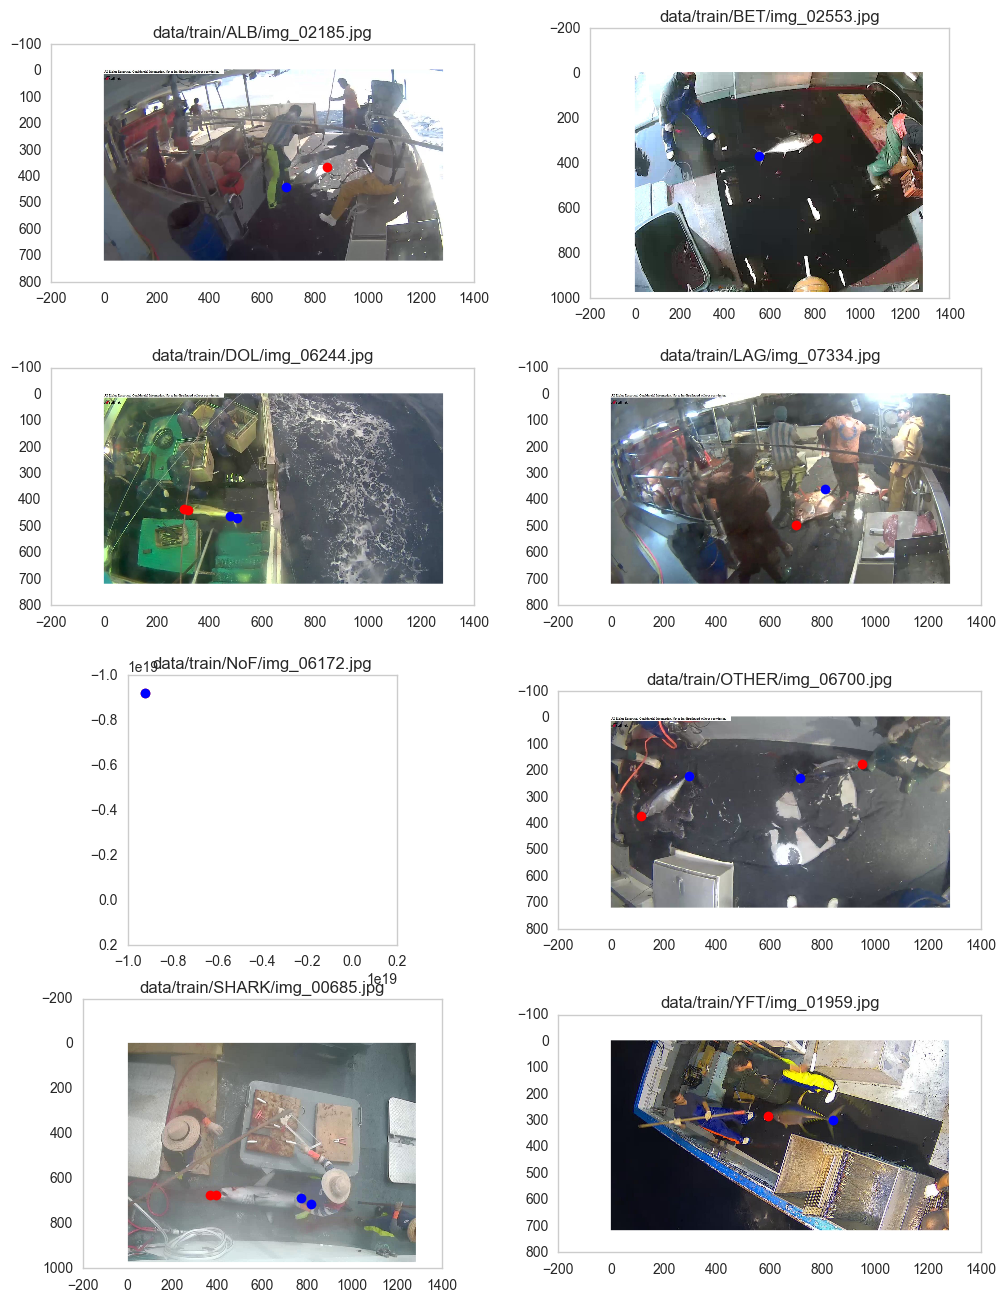

In [12]:
# sample an image per class of fish
fishes = df_full.groupby('category').apply(lambda x: x.sample(1))
f = plt.figure(figsize=(12,16))
for i in range(len(fishes)):
    # get image path
    fpath = fishes.iloc[i]['fpath']
    fname = fishes.iloc[i]['fname']
    img = io.imread(fpath)
    # get all annotations for that image
    anno = df_full.loc[df_full['fname']==fname,['head_x','head_y','tail_x','tail_y']]
    head_x, head_y, tail_x, tail_y = \
    np.array(anno['head_x'],dtype='int'), np.array(anno['head_y'],dtype='int'),\
    np.array(anno['tail_x'],dtype='int'), np.array(anno['tail_y'],dtype='int')
    ax = plt.subplot(4,2,i+1)
    ax.imshow(img)
    ax.set_title(fpath)
    ax.plot(head_x,head_y,'ro')
    ax.plot(tail_x,tail_y,'bo')



Before we start training our model, we need a few things:
 - Data Generator (train, valid, test, with augmentation)
 - Model Specification and weights (borrowed from [here](https://github.com/fchollet/deep-learning-models))

## Data Generator

Given the small amount of data provided, and the correlated nature of some of these images (from the same video camera on the same boat), we need to heavily augment the data provided to prevent our model from 'memorising' the extraneous features, such as the boat, fishermen, etc. We will use:
 - horizontal/vertical flips (TODO)
 - +-15% rotations
 - crops
 - chance of occluding the fish and switching the label to 'NoF'
 - chance of blurring the fish while preserving the label

To make the generator generalizable to both coordinate and detection predictions, we use a `return_type` and `p_remove` parameters to denote the type to return, and the probability of occlusion. We do not want any occlusion of the single fish kept for the `return_type` of `coord`, and so `p_remove` should be set to 0.

(224, 224, 3) 0


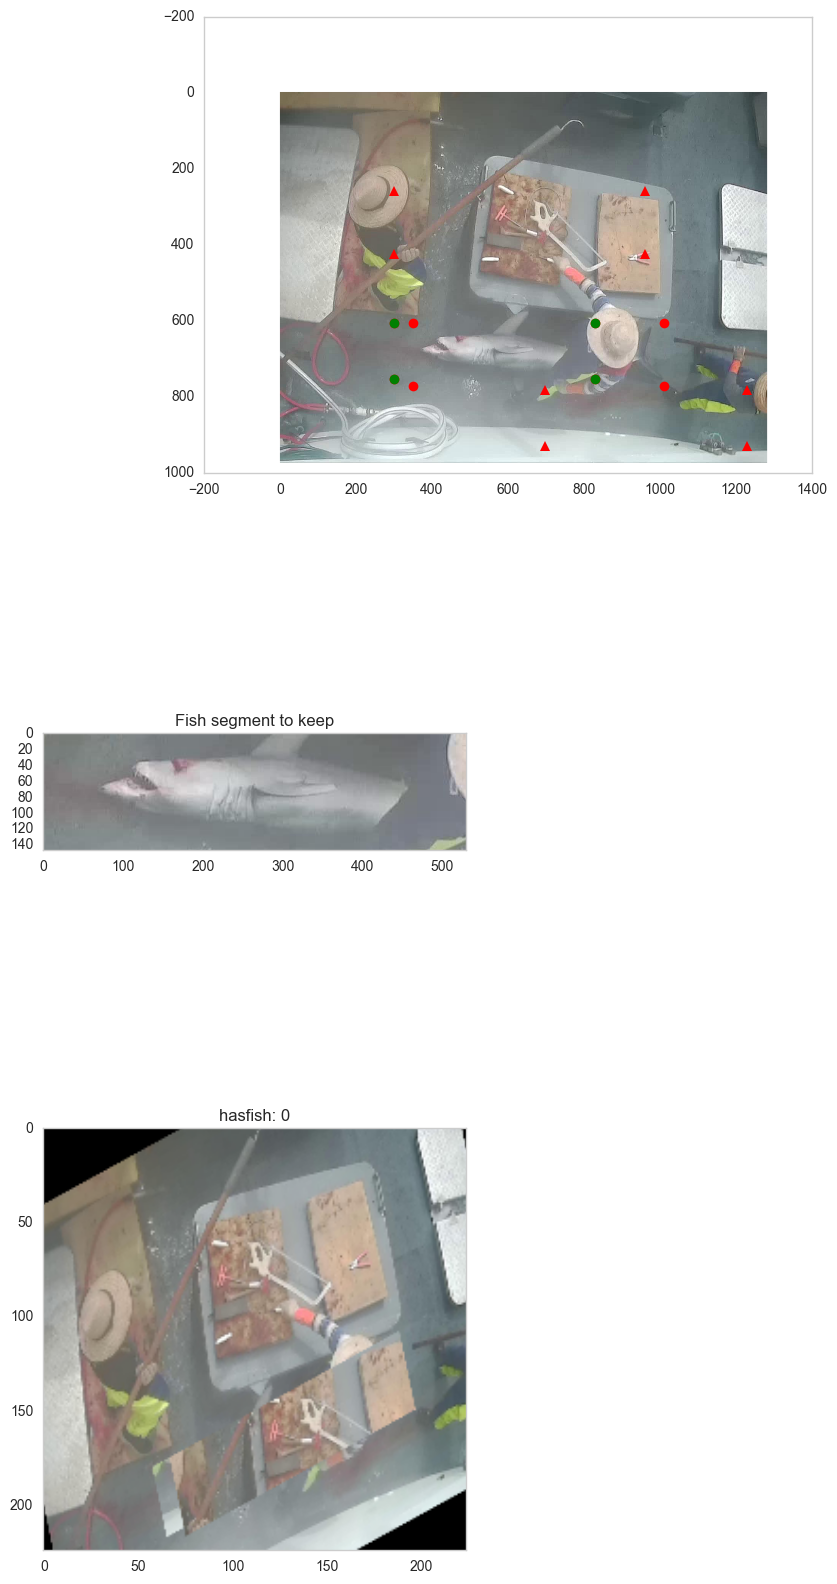

In [13]:
# helper functions

# takes a bounding box and checks if contains any of the annotated marks are inside
def contains(bbox,df_marks,bounding_buffer=30):
    x_min,x_max,y_min,y_max = bbox
    x_mins = df_marks.loc[:,['head_x','tail_x']].min(axis=1)
    x_maxs = df_marks.loc[:,['head_x','tail_x']].max(axis=1)
    y_mins = df_marks.loc[:,['head_y','tail_y']].min(axis=1)
    y_maxs = df_marks.loc[:,['head_y','tail_y']].max(axis=1)
    conds = ~((x_mins + bounding_buffer > x_min) & (x_maxs - bounding_buffer < x_max) \
              & (y_mins + bounding_buffer > y_min) & (y_maxs - bounding_buffer < y_max))
    return ~(conds.all())

# convenience function for bounding values within a max and min value (to prevent under/over-indexing the image)
def bound(val,val_max,val_min):
    return max(min(val,val_max),val_min)

# performs various distortions to the image and the corresponding annotated label, coords
def augment(df_marks,return_type,rng,p_remove=0.5,buffer_x_pct=0.15,buffer_y_pct=0.15,
           buffer_x_min=70,buffer_y_min=70,w_out=224,h_out=224,if_plot=False):
    fpath = df_marks['fpath'].iloc[0]
    img = io.imread(fpath)
    h_img, w_img, ch_img = img.shape
    if if_plot:
        f = plt.figure(figsize=(12,20))
        plt.subplot(311)
        plt.imshow(img)
    # get category (if a fish is present or not)
    category = df_marks.iloc[0]['category']
    hasfish = 0 if category=='NoF' else 1

    # if fish present, perform occlusion
    if hasfish:
        if rng.rand() < p_remove:
            # swap label, occlude all fish annotations with random part
            hasfish = 0
        # else keep 1 random fish annotation, and occlude all other fishes
        indices = rng.permutation(df_marks.index)
        i_keep = indices[0] # take the first amongst the shuffled fish indices
        for ix in indices:
            # get inner bounding box
            x_min = bound(int(min(df_marks.loc[ix,'head_x'],df_marks.loc[ix,'tail_x'])),w_img,0)
            x_max = bound(int(max(df_marks.loc[ix,'head_x'],df_marks.loc[ix,'tail_x'])),w_img,0)
            y_min = bound(int(min(df_marks.loc[ix,'head_y'],df_marks.loc[ix,'tail_y'])),h_img,0)
            y_max = bound(int(max(df_marks.loc[ix,'head_y'],df_marks.loc[ix,'tail_y'])),h_img,0)
            # expand bounding box
            h_box, w_box = y_max - y_min, x_max - x_min
            buffer_x = int(max(buffer_x_min,w_box * buffer_x_pct))
            buffer_y = int(max(buffer_y_min,h_box * buffer_y_pct))
            x_min = bound(x_min - buffer_x, w_img, 0)
            y_min = bound(y_min - buffer_y, h_img, 0)
            x_max = bound(x_max + buffer_x, w_img, 0)
            y_max = bound(y_max + buffer_y, h_img, 0)
            if if_plot:
                plt.plot(x_min,y_min,'ro')
                plt.plot(x_min,y_max,'ro')
                plt.plot(x_max,y_min,'ro')
                plt.plot(x_max,y_max,'ro')
            h_box, w_box = y_max - y_min, x_max - x_min
            assert(h_box > 0 and w_box > 0)
            # if keep, make a copy of the fish in the original position, store in keep
            if ix == i_keep:
                if if_plot:
                    plt.plot(x_min,y_min,'go')
                    plt.plot(x_min,y_max,'go')
                    plt.plot(x_max,y_min,'go')
                    plt.plot(x_max,y_max,'go')
                # our annotated values need not be bounded between 0 to w or h, 
                # as we want to be able to preserve the proportions of the fish when cropping
                x_head = int(df_marks.loc[ix,'head_x'])
                x_tail = int(df_marks.loc[ix,'tail_x'])
                y_head = int(df_marks.loc[ix,'head_y'])
                y_tail = int(df_marks.loc[ix,'tail_y'])
                keep = img[y_min:y_max,x_min:x_max,:].copy()
                if if_plot:
                    plt.subplot(323)
                    plt.imshow(keep)
                    plt.title('Fish segment to keep')
                    plt.subplot(311)
                x_keep_min, y_keep_min = x_min, y_min
                h_keep, w_keep = h_box, w_box
            # get another random box of a similar size that doesn't contain a fish
            x_swap_min = int(rng.uniform(0,w_img-w_box,1))
            y_swap_min = int(rng.uniform(0,h_img-h_box,1))
            x_swap_max = x_swap_min + w_box
            y_swap_max = y_swap_min + h_box
            bbox = (x_swap_min,x_swap_max,y_swap_min,y_swap_max)
            while contains(bbox,df_marks):
                x_swap_min = int(rng.uniform(0,w_img-w_box,1))
                y_swap_min = int(rng.uniform(0,h_img-h_box,1))
                x_swap_max = x_swap_min + w_box
                y_swap_max = y_swap_min + h_box
                bbox = (x_swap_min,x_swap_max,y_swap_min,y_swap_max)
            if if_plot:
                plt.plot(x_swap_min,y_swap_min,'r^')
                plt.plot(x_swap_min,y_swap_min+h_box,'r^')
                plt.plot(x_swap_min+w_box,y_swap_min,'r^')
                plt.plot(x_swap_min+w_box,y_swap_min+h_box,'r^')
            # copy over random box
            random_box = img[y_swap_min:(y_swap_min+h_box),
                x_swap_min:(x_swap_min+w_box),:].copy()
            img[y_min:y_max,x_min:x_max,:] = random_box
        # put a fish back in a random position
        if hasfish:
            if if_plot:
                plt.plot(x_head,y_head,'yo')
                plt.plot(x_tail,y_tail,'yo')
                plt.plot(x_head,y_head,'yo')
                plt.plot(x_tail,y_tail,'yo')
            x_swap_min = int(rng.uniform(0,w_img-w_keep,1))
            y_swap_min = int(rng.uniform(0,h_img-h_keep,1))
            x_diff = x_swap_min - x_keep_min
            y_diff = y_swap_min - y_keep_min
            x_head = x_head + x_diff
            x_tail = x_tail + x_diff
            y_head = y_head + y_diff
            y_tail = y_tail + y_diff
            if if_plot:
                plt.plot(x_head,y_head,'yo')
                plt.plot(x_tail,y_tail,'yo')
                plt.plot(x_head,y_head,'yo')
                plt.plot(x_tail,y_tail,'yo')
            img[y_swap_min:(y_swap_min+h_keep), \
                x_swap_min:(x_swap_min+w_keep),:] = keep
            if if_plot:
                plt.subplot(324)
                plt.imshow(img)
                plt.plot(x_swap_min,y_swap_min,'bo')
                plt.plot(x_swap_min,y_swap_min+h_keep,'bo')
                plt.plot(x_swap_min+w_keep,y_swap_min,'bo')
                plt.plot(x_swap_min+w_keep,y_swap_min+h_keep,'bo')
            
    
    # perform affine transformations
    r_tx, r_ty = rng.normal(w_img/2,50,1)[0], rng.normal(h_img/2,50,1)[0]
    r_tx = 0 if r_tx < 0 else w_img if r_tx > w_img else int(r_tx)
    r_ty = 0 if r_ty < 0 else h_img if r_ty > h_img else int(r_ty)
    r_rotate = rng.uniform(-np.pi/6,np.pi/6,1)[0]
    tf_rotate = tf.SimilarityTransform(rotation=r_rotate)
    tf_scale = tf.SimilarityTransform(scale=rng.uniform(0.8,1.5,1))
    tf_shear = tf.AffineTransform(shear=rng.uniform(-0.5,0.5,1))
    tf_shift = tf.SimilarityTransform(translation=[-r_tx, -r_ty])
    tf_shift_inv = tf.SimilarityTransform(translation=[r_tx, r_ty])
    trans = tf_shift + tf_scale + tf_shear + tf_rotate + tf_shift_inv

    img_warped = tf.warp(img, trans.inverse)
    img_final = tf.resize(img_warped,(h_out,w_out))

    if return_type == 'coord':
        head = np.matmul(trans.params[:2,:],np.array([x_head,y_head,1]))
        tail = np.matmul(trans.params[:2,:],np.array([x_tail,y_tail,1]))
        # rescale coordinates to output shape
        head[0] = head[0] / w_img * w_out
        head[1] = head[1] / h_img * h_out
        tail[0] = tail[0] / w_img * w_out
        tail[1] = tail[1] / h_img * h_out
        
    if if_plot:
        plt.subplot(325)
        plt.title('hasfish: %d' % hasfish)
        plt.imshow(img_final)
        if return_type == 'coord':
            plt.plot(head[0],head[1],'go')
            plt.plot(tail[0],tail[1],'bo')
    
    if return_type == 'contain':
        return img_final, hasfish
    elif return_type == 'coord':
        return img_final, np.array([head[0],head[1],tail[0],tail[1]])
    else:
        print('Unexpected return type %s. Please specify "contain" or "coord".' % return_type)

fpath = df_full.fpath.sample(n=1).iloc[0]
fpath = 'data/train/SHARK/img_06410.jpg'
df_marks = df_full.loc[df_full['fpath']==fpath]
im,hasfish = augment(df_marks,'contain',np.random.RandomState(2),if_plot=True)
print(im.shape,hasfish)

In [14]:
def gen(df_gen, return_type='contain', batch_size=32, rng=None, hX=224, wX=224, chX=3):
    """
    This generator produces a batch of (X,y) for training a fish detector.
    Images are randomly augmented.
    
    Inputs:
    df_gen is a pandas dataframe containing the file path (fpath), 
    potentially multiple head and tail annotations
    return_type is string of either 'contain' or 'coord'
    
    Outputs:
    X is a 4D tensor of shape (batch_size,h,w,ch)
    y is a binary vector with 1 if the image has a fish else 0
    """
    if return_type not in ['contain','coord']:
        raise ValueError('Invalid return type %s' % return_type)
    if rng is None:
        rng = np.random.RandomState(241016)
    fishes = df_gen['fpath'].unique()
    n = len(fishes)
    total_batch = int(np.ceil(n / batch_size))
    logging.info('generating %d batches with %d samples per epoch' % (total_batch,n))
    
    while True:
        # shuffle examples every epoch
        fishes_shuffled = fishes[rng.permutation(n)]
        for i_batch in range(total_batch):
            # limit end index by size of df_gen to prevent 
            # indexing up to the next multiple of batch_size
            i_start, i_end = i_batch * batch_size, min((i_batch + 1) * batch_size,n)
            i_batch_size = i_end - i_start
            X = np.zeros((i_batch_size,hX,wX,chX))
            if return_type == 'contain':
                Y = np.zeros(i_batch_size)
            else:
                Y = np.zeros((i_batch_size,4))
            for i_fish in range(i_start,i_end):
                i_fpath = fishes_shuffled[i_fish]
                df_marks = df_gen.loc[df_gen['fpath']==i_fpath]
                x,y = augment(df_marks,return_type,rng) # augment image
                i_intrabatch = i_fish - i_start
                X[i_intrabatch,:] = x
                Y[i_intrabatch] = y
            logging.info('yielding batch %d of size %d' % (i_batch, i_batch_size))
            yield (X,Y)

In [15]:
# visual test: generate a batch of 6 and print the plots
bs = 6
gen_train = gen(df_full[df_full['category'] != 'NoF'],'coord',6,np.random.RandomState(1))
X,Y = next(gen_train)
plt.figure(figsize=(12,16))
for i in range(bs):
    plt.subplot('32'+str(i+1))
    plt.imshow(X[i,...])
    if len(Y.shape) > 1:
        plt.plot(Y[i,0],Y[i,1],'ro')
        plt.plot(Y[i,2],Y[i,3],'bo')
    else:
        plt.title(Y[i])


Having built a reliable generator for supplying a stream of augmented images that can produce both binary responses (1 if a fish is present) and real-valued coordinates, we move on to define a model that will consume these augmented images to predict whether the image contains a fish (as a first cut benchmark).

## Model Definition

We begin with a standard VGG16 network, which we'll download via keras. We prefer the tensorflow backend here, due to the convenience of its image ordering (h,w,ch) as opposed to (ch,h,w), which allows us to plot the pictures directly when debugging. While keras.applications has a VGG16 model initializer, we use a self-defined network for easy weight customizations from the hdf5 file, and to swap out the softmax layer easily.

In [50]:
import h5py
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Input, Convolution2D, MaxPooling2D, ZeroPadding2D, Layer
from keras.layers import Activation, Dropout, Flatten, MaxoutDense, Dense
from keras import backend as K

K.set_image_dim_ordering('tf')

# path to the model weights files.
weights_path = 'models/vgg16_tf.h5'

# if first time, download and save weights
if not os.path.exists(weights_path):
    from keras.applications.vgg16 import VGG16
    vgg16 = VGG16(weights='imagenet')
    vgg16.save_weights(weights_path)

# dimensions of our images.
img_width, img_height = 224, 224

# custom layer for getting all max for 'contain' model
class AllMax(Layer):
    def get_output_shape_for(self, input_shape):
        shape = list(input_shape)
        assert len(shape) == 2  # only valid for 2D tensors
        return (input_shape[0],1)

    def call(self, x, mask=None):
        return K.max(x, axis=1, keepdims=True)


conv_names = ['block1_conv1','block1_conv2',
              'block2_conv1','block2_conv2',
              'block3_conv1','block3_conv2','block3_conv3',
              'block4_conv1','block4_conv2','block4_conv3',
              'block5_conv1','block5_conv2','block5_conv3']

# initialize weights
def init_weights(model,weights_path='models/vgg16_tf.h5'):
    # read in weights, prevent weights from changing
    f = h5py.File(weights_path)
    for cn in conv_names:
        g = f[cn]
        l = model.get_layer(cn)
        wb = []
        for w in g:
            wb.append(g[w])
        l.set_weights(wb)
    f.close()
    return model

# construct model architecture
def vgg_16(model_type, weights_path='models/vgg16_tf.h5'):
	inputs = Input(shape=(224,224,3))
	b1 = ZeroPadding2D((1,1))(inputs)
	b1 = Convolution2D(64,3,3,activation='relu',name='block1_conv1')(b1)
	b1 = ZeroPadding2D((1,1))(b1)
	b1 = Convolution2D(64,3,3,activation='relu',name='block1_conv2')(b1)
	b1 = MaxPooling2D((2,2),strides=(2,2))(b1)

	b2 = ZeroPadding2D((1,1))(b1)
	b2 = Convolution2D(128,3,3,activation='relu',name='block2_conv1')(b2)
	b2 = ZeroPadding2D((1,1))(b2)
	b2 = Convolution2D(128,3,3,activation='relu',name='block2_conv2')(b2)
	b2 = MaxPooling2D((2,2),strides=(2,2))(b2)

	b3 = ZeroPadding2D((1,1))(b2)
	b3 = Convolution2D(256,3,3,activation='relu',name='block3_conv1')(b3)
	b3 = ZeroPadding2D((1,1))(b3)
	b3 = Convolution2D(256,3,3,activation='relu',name='block3_conv2')(b3)
	b3 = ZeroPadding2D((1,1))(b3)
	b3 = Convolution2D(256,3,3,activation='relu',name='block3_conv3')(b3)
	b3 = MaxPooling2D((2,2),strides=(2,2))(b3)

	b4 = ZeroPadding2D((1,1))(b3)
	b4 = Convolution2D(512,3,3,activation='relu',name='block4_conv1')(b4)
	b4 = ZeroPadding2D((1,1))(b4)
	b4 = Convolution2D(512,3,3,activation='relu',name='block4_conv2')(b4)
	b4 = ZeroPadding2D((1,1))(b4)
	b4 = Convolution2D(512,3,3,activation='relu',name='block4_conv3')(b4)
	b4 = MaxPooling2D((2,2),strides=(2,2))(b4)

	b5 = ZeroPadding2D((1,1))(b4)
	b5 = Convolution2D(512,3,3,activation='relu',name='block5_conv1')(b5)
	b5 = ZeroPadding2D((1,1))(b5)
	b5 = Convolution2D(512,3,3,activation='relu',name='block5_conv2')(b5)
	b5 = ZeroPadding2D((1,1))(b5)
	b5 = Convolution2D(512,3,3,activation='relu',name='block5_conv3')(b5)
	b5 = MaxPooling2D((2,2),strides=(2,2))(b5)

	if model_type == 'contain':
		bpool = MaxPooling2D((7,7))(b5) # pool over the whole area
		bpool = Flatten(input_shape=bpool.get_shape().as_list()[1:])(bpool)
		bpool = AllMax()(bpool)
		predictions = Dense(1, activation='softmax')(bpool)
		m = Model(input=inputs, output=predictions)
		init_weights(m, weights_path)
		m.compile(loss='binary_crossentropy',
			optimizer=optimizers.SGD(lr=1e-4, momentum=0.9, nesterov=True),
			metrics=['binary_accuracy','matthews_correlation','fmeasure'])
	elif model_type == 'coord':
		b6 = Flatten(input_shape=b5.get_shape().as_list()[1:])(b5)
		b6 = Dense(1024, activation='relu')(b6)
		b6 = Dropout(0.5)(b6)
		b6 = Dense(1024, activation='relu')(b6)
		b6 = Dropout(0.5)(b6)
		predictions = Dense(4)(b6)
		m = Model(input=inputs, output=predictions)
		init_weights(m, weights_path)
		m.compile(loss='mean_squared_error',
			optimizer=optimizers.SGD(lr=1e-3, momentum=0.9, nesterov=True),
			metrics=['mean_absolute_error'])
	return m

In [51]:
m_contain1 = vgg_16('contain')
m_coord1 = vgg_16('coord')

Before we train our model, we need to add some model-specific pre-processing in the generator, namely, per channel mean-shifting. We still use the same `augment` and `contains` helper functions from before.

In [43]:
def gen(df_gen, return_type='contain', batch_size=32, rng=None, hX=224, wX=224, chX=3):
    """
    This generator produces a batch of (X,y) for training a fish detector.
    Images are randomly augmented.
    
    Inputs:
    df_gen is a pandas dataframe containing the file path (fpath), 
    potentially multiple head and tail annotations
    return_type is string of either 'contain' or 'coord'
    rng is a np.random.RandomState object for reproducibility of the generated images
    
    Outputs:
    X is a 4D tensor of shape (batch_size,h,w,ch)
    y is a binary vector with 1 if the image has a fish else 0
    """
    if return_type not in ['contain','coord']:
        raise ValueError('Invalid return type %s' % return_type)
    if rng is None:
        rng = np.random.RandomState(241016)
    fishes = df_gen['fpath'].unique()
    n = len(fishes)
    total_batch = int(np.ceil(n / batch_size))
    logging.info('generating %d batches with %d samples per epoch' % (total_batch,n))
    
    while True:
        # shuffle examples every epoch
        fishes_shuffled = fishes[rng.permutation(n)]

        for i_batch in range(total_batch):
            # limit end index by size of df_gen to prevent 
            # indexing up to the next multiple of batch_size
            i_start, i_end = i_batch * batch_size, min((i_batch + 1) * batch_size,n)
            i_batch_size = i_end - i_start
            X = np.zeros((i_batch_size,hX,wX,chX))
            if return_type == 'contain':
                Y = np.zeros(i_batch_size)
            else:
                Y = np.zeros((i_batch_size,4))
            for i_fish in range(i_start,i_end):
                i_fpath = fishes_shuffled[i_fish]
                df_marks = df_gen.loc[df_gen['fpath']==i_fpath]
                x,y = augment(df_marks,return_type,rng) # augment image
                i_intrabatch = i_fish - i_start
                X[i_intrabatch,:] = x
                Y[i_intrabatch] = y

            # per channel mean-shifting (RGB)
            X[:,:,:,0] -= 123.68
            X[:,:,:,1] -= 116.779
            X[:,:,:,2] -= 103.939
            logging.info('yielding batch %d of size %d' % (i_batch, i_batch_size))
            yield (X,Y)

Here's how we will be splitting our training data (images):

 - 10% holdout (no training at all, to estimate the holdout error)
 - 30% fold 0 (24% train, 6% valid)
 - 30% fold 1 (24% train, 6% valid)
 - 30% fold 2 (24% train, 6% valid)
 
**L1**

For each level 1 model (Fish detector, Fish localizer+classifier), we will train on 2 folds, then predict the probability on the 3rd unused fold, and the holdout set. We combine the data from the 2 folds, and  We repeat this 3 times to get probabilities on all 3 folds. We explore 2 different models:

 - A binary fish detector 
  - 1 if the image has a fish
  - trained on all pictures
 - A fish localizer + classifier
  - probability given that the image has a fish
  - trained on pictures with fish and annotations

This should give us the following split:

 - 10% holdout with L1 probabilities
 - 90% with L1 probabilities (from folds 1,2,3)

**L2**

We can then train + tune an xgboost classifier with as many folds as we want (5 probably) on the 90% data with L1 probabilities, and use that model to predict for the 10% holdout, to get an estimate of the predicted log-loss on the test set.

**hyperparameters**

At the L1 stage, we do not bother with tuning the convnet's hyper-parameters as it would be prohibitively costly to tune. Ad-hoc experimentation is performed to determine a reasonable set of parameters / architecture for our convnet(s).

In [46]:
rng = np.random.RandomState(290615)
fpath_contain_uniq = df_full['fpath'].unique()
fpath_coord_uniq = df_full.ix[df_full.category != 'NoF']['fpath'].unique()

# each pair of 0.24,0.06 probabilities correspond to a train,valid fold, with 0.1 being the holdout
ix_contain = rng.choice(range(7),p=[0.24,0.06,0.24,0.06,0.24,0.06,0.1],size=len(fpath_contain_uniq))
ix_coord = rng.choice(range(7),p=[0.24,0.06,0.24,0.06,0.24,0.06,0.1],size=len(fpath_coord_uniq))

df_contain_fold0_train = df_full[df_full['fpath'].isin(fpath_contain_uniq[(ix_contain==0) | (ix_contain==2)])]
df_contain_fold1_train = df_full[df_full['fpath'].isin(fpath_contain_uniq[(ix_contain==2) | (ix_contain==4)])]
df_contain_fold2_train = df_full[df_full['fpath'].isin(fpath_contain_uniq[(ix_contain==4) | (ix_contain==0)])]
df_contain_fold0_valid = df_full[df_full['fpath'].isin(fpath_contain_uniq[(ix_contain==1) | (ix_contain==3)])]
df_contain_fold1_valid = df_full[df_full['fpath'].isin(fpath_contain_uniq[(ix_contain==3) | (ix_contain==5)])]
df_contain_fold2_valid = df_full[df_full['fpath'].isin(fpath_contain_uniq[(ix_contain==5) | (ix_contain==1)])]
df_contain_fold_out = df_full[df_full['fpath'].isin(fpath_contain_uniq[ix_contain==6])]

df_coord_fold0_train = df_full[df_full['fpath'].isin(fpath_coord_uniq[(ix_coord==0) | (ix_coord==2)])]
df_coord_fold1_train = df_full[df_full['fpath'].isin(fpath_coord_uniq[(ix_coord==2) | (ix_coord==4)])]
df_coord_fold2_train = df_full[df_full['fpath'].isin(fpath_coord_uniq[(ix_coord==4) | (ix_coord==0)])]
df_coord_fold0_valid = df_full[df_full['fpath'].isin(fpath_coord_uniq[(ix_coord==1) | (ix_coord==3)])]
df_coord_fold1_valid = df_full[df_full['fpath'].isin(fpath_coord_uniq[(ix_coord==3) | (ix_coord==5)])]
df_coord_fold2_valid = df_full[df_full['fpath'].isin(fpath_coord_uniq[(ix_coord==5) | (ix_coord==1)])]
df_coord_fold_out = df_full[df_full['fpath'].isin(fpath_coord_uniq[ix_coord==6])]


Note the data frames for each fold are not of a uniform size as a picture may contain multiple annotations, leading to multiple rows for the same picture.

In [ ]:
# for fold 0, contain:
gn_contain_fold0_train = gen(df_contain_fold0_train,'contain',batch_size=32,rng=np.random.RandomState(290615))
gn_contain_fold0_valid = gen(df_contain_fold0_valid,'contain',batch_size=32,rng=np.random.RandomState(290615))
samples_per_epoch0 = len(df_contain_fold0_train['fpath'].unique())
nb_val_samples0 = len(df_contain_fold0_valid['fpath'].unique())

m_contain1.fit_generator(generator=gn_contain_fold0_train,
                 samples_per_epoch=samples_per_epoch0,
                 validation_data=gn_contain_fold0_valid,
                 nb_val_samples=nb_val_samples0,
                 nb_epoch=5)

We build a model for the coordinate regression model, but only on non-NoF classes:

In [ ]:
gn_coord_fold0_train = gen(df_coord_fold0_train,'coord',batch_size=32,rng=np.random.RandomState(290615))
gn_coord_fold0_valid = gen(df_coord_fold0_valid,'coord',batch_size=32,rng=np.random.RandomState(290615))
samples_per_epoch0 = len(df_coord_fold0_train['fpath'].unique())
nb_val_samples0 = len(df_coord_fold0_valid['fpath'].unique())

m_coord1.fit_generator(generator=gn_coord_fold0_train,
                 samples_per_epoch=samples_per_epoch0,
                 validation_data=gn_coord_fold0_valid,
                 nb_val_samples=nb_val_samples0,
                 nb_epoch=5)

In [48]:
# TODO add in prediction on sample generated images
